In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ckmadhavan","key":"61753a51b598418abcad16b70b22f982"}'}

In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [3]:
!kaggle datasets download -d ckmadhavan/percentageforestcoverdataset

 46% 13.0M/28.5M [00:00<00:00, 129MB/s]
100% 28.5M/28.5M [00:00<00:00, 172MB/s]


In [4]:
!unzip -q /content/percentageforestcoverdataset.zip -d /content

In [5]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output

In [6]:
original_imgs = []
output_percentages = []

In [7]:
df = pd.read_csv('/content/new_data.csv')
image_directory = '/content/original/'

for i in range(len(df)):
  img = plt.imread(image_directory + df.loc[i]['image_name'])
  original_imgs.append(img)
  output_percentages.append(df.loc[i]['forestation coverage'])

In [8]:
print(len(original_imgs), len(output_percentages))

4597 4597


In [9]:
X_train = np.array(original_imgs[:4000]).reshape(-1,128,128,3)
y_train = np.array(output_percentages[:4000]).reshape(-1,1)

X_val = np.array(original_imgs[4000:4300]).reshape(-1,128,128,3)
y_val = np.array(output_percentages[4000:4300]).reshape(-1,1)

X_test = np.array(original_imgs[4300:]).reshape(-1,128,128,3)
y_test = np.array(output_percentages[4300:]).reshape(-1,1)

In [10]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(4000, 128, 128, 3) (4000, 1)
(300, 128, 128, 3) (300, 1)
(297, 128, 128, 3) (297, 1)


In [11]:
def bounded_relu(x):

  lower_bounded = keras.backend.maximum(x, 0)
  bounded = keras.backend.minimum(x, 100)

  return bounded

In [12]:
im_size = 128

In [13]:
inp = keras.layers.Input(shape = (im_size,im_size,3))

pre_trained_model = keras.applications.EfficientNetB7(include_top = False , input_tensor=inp , weights = 'imagenet' , input_shape = (im_size,im_size,3))
for layer in pre_trained_model.layers[:-len(pre_trained_model.layers)//2]:
    layer.trainable = False

o = keras.layers.GlobalAveragePooling2D()(pre_trained_model.output)
o = keras.layers.Dense(256, activation = 'relu')(o)
o = keras.layers.BatchNormalization()(o)
o = keras.layers.Dropout(0.4)(o)
z = keras.layers.Dense(128, activation = 'relu')(o)
z = keras.layers.BatchNormalization()(z)
z = keras.layers.Dropout(0.4)(z)
z = keras.layers.Dense(64, activation = 'relu')(z)
z = keras.layers.BatchNormalization()(z)
z = keras.layers.Dense(1 , activation = bounded_relu)(z)

model = keras.models.Model(inputs=inp, outputs=z)

258076736/258076736 [==============================] - 1s 0us/step


In [14]:
model.compile(loss='mse', optimizer='adam')

In [15]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.val_losses = []
        self.losses = []

        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.val_losses.append(logs.get('val_loss'))
        self.losses.append(logs.get('loss'))
        self.i += 1

        clear_output(wait=True)
        plt.plot(self.x, self.val_losses, label="val_loss" , marker ='o')
        plt.plot(self.x, self.losses, label="loss" , marker ='o')
        plt.legend()
        plt.show()

plot_losses = PlotLosses()

In [16]:
!mkdir output

In [17]:
checkpoint = keras.callbacks.ModelCheckpoint('/content/output/best.h5',
    verbose=1,
    monitor='val_loss',
    save_best_only=True,
    mode='auto'
)

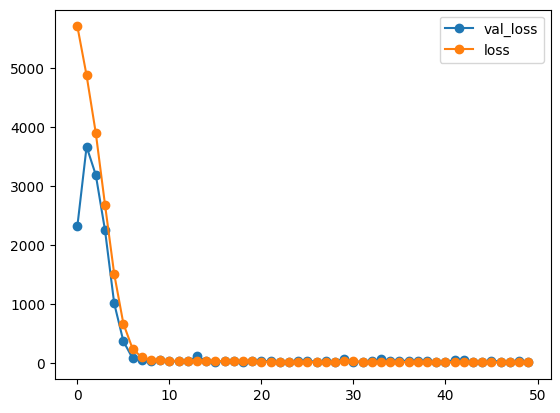


Epoch 50: val_loss did not improve from 22.01196
125/125 [==============================] - 36s 286ms/step - loss: 15.0649 - val_loss: 29.0953


In [18]:
NUM_EPOCHS = 50

model.fit(X_train , y_train , epochs = NUM_EPOCHS, validation_data = (X_val, y_val), callbacks = [plot_losses, checkpoint])

In [19]:
for i in range(10):
  print(model.predict(X_test[i].reshape(1,128,128,3))[0][0], y_test[i][0])

1/1 [==============================] - 7s 7s/step
95.35721 95.39794921875
1/1 [==============================] - 0s 49ms/step
100.0 100.0
1/1 [==============================] - 0s 42ms/step
94.22399 95.343017578125
1/1 [==============================] - 0s 46ms/step
90.36816 87.04833984375
1/1 [==============================] - 0s 43ms/step
83.14018 88.470458984375
1/1 [==============================] - 0s 42ms/step
100.0 100.0
1/1 [==============================] - 0s 41ms/step
53.585464 48.480224609375
1/1 [==============================] - 0s 56ms/step
4.3817897 5.04150390625
1/1 [==============================] - 0s 44ms/step
99.683754 98.992919921875
1/1 [==============================] - 0s 48ms/step
27.125126 21.875


In [20]:
model.save('/content/output/final.h5')

In [21]:
model.save_weights('/content/output/final_weights.h5')

In [25]:
!rm -r /content/drive/MyDrive/ForestOutput/*

In [26]:
!cp -a /content/output/* /content/drive/MyDrive/ForestOutput/